In [2]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
from flax.training import train_state
from jax import random

import pandas as pd
import matplotlib.pyplot as plt

import time
import sys
import os

p = os.path.abspath(os.path.join('..', '00_utils'))

# Add the directory to sys.path
if p not in sys.path:
    sys.path.append(p)

from collocation import compute_weights, lagrange_derivative
#from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
#from optimization_pyomo import ODEOptimizationModel as ODEOptimizationModel
#from pickle_func import pickle_data, unpickle_data

# -------------- regular neural nets --------------
# RELOADING MODULES
import importlib
import neural_net_jax
importlib.reload(neural_net_jax)
NeuralODE_JAX = neural_net_jax.NeuralODE

import data_generation
importlib.reload(data_generation)
generate_ode_data = data_generation.generate_ode_data

# ----------------- diffrax code -----------------
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax.nn as jnn
import jax.random as jr
import optax  # https://github.com/deepmind/optax


In [68]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 400
noise_level = 0.05
ode_type, params = "sinusoidal_oscillator", {"A": 2}
start_time, end_time = 0, 10
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

In [4]:
u_noisy = np.atleast_2d(y_noisy).T
r, c = u_noisy.shape
print(f"r : {r}; c : {c}")

u_estimated = np.atleast_2d(estimated_solution).T
r, c = u_estimated.shape
print(f"r : {r}; c : {c}")

r : 400; c : 1
r : 400; c : 1


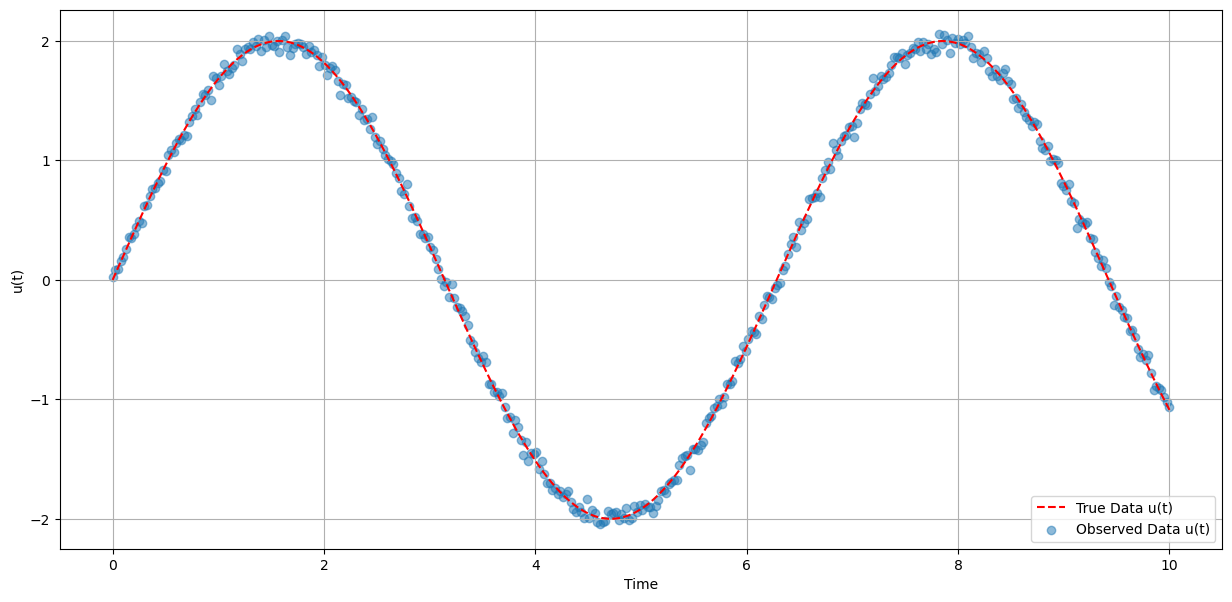

In [5]:
#result = y_pred_results[0]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
#plt.plot(t, y_train_pred, 'b', label='Predicted Solution u(t)')
#plt.plot(t_test_ho[N-1:], result['y_test_pred'].T, 'b', label='Predicted Solution u(t')

plt.plot(t, y, 'r--', label='True Data u(t)') 
plt.scatter(t, u_noisy, label='Observed Data u(t)', alpha=0.5) 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

## `Regular JAX Odeint training`

In [108]:
def create_delayed_embeddings(x, tau, m):
    n = x.shape[0]  
    
    embeddings = []  
    
    for i in range(n - m * tau):
        if x.ndim == 2:
             embedding = jnp.array([x[i + j * tau, 0] for j in range(m)])  
        elif x.ndim == 1:
            embedding = jnp.array([x[i + j * tau] for j in range(m)])     
        else:
            raise ValueError("Input array x must be either 1D or 2D.")
        embeddings.append(embedding)
    
    return jnp.vstack(embeddings)

In [109]:
tau = 1
m = 5
embeddings = create_delayed_embeddings(y_noisy, tau, m)

* t[offset : i]
* embeddings[: i - offset]
* the train-test split is set at 300 + offset

In [110]:
embeddings.shape

(395, 5)

In [111]:
importlib.reload(neural_net_jax)
NeuralODE_JAX = neural_net_jax.NeuralODE

# node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

### `Train`

In [113]:
y_pred_results = {}
offset = m * tau

layer_widths = [1 + m, 32, 1]
learning_rate = 1e-3
rng = random.PRNGKey(42)

node_model = NeuralODE_JAX(layer_widths, time_invariant=True)
state = node_model.create_train_state(rng, learning_rate)

for i in [50, 300]:
    state = node_model.train(state, t[offset:i + offset], u_noisy[offset:i + offset], 
                             y[offset], num_epochs = 1000, 
                             extra_args = (embeddings[: i], t[offset:i + offset]))
#state = node_model.train(state, t, u_noisy, y[0], num_epochs = 1000)

Epoch 100, Loss: 1.3757352512646401


KeyboardInterrupt: 

* train predictions can be done using the original `embeddings` vector

In [161]:
offset

5

In [13]:
y_train_pred = node_model.neural_ode(state.params, y[offset], t[offset : 300+offset], state, (embeddings[:300], t[offset : 300+offset]))

In [ ]:
# y_train_pred = node_model.neural_ode(state_archive.params, y[offset], t[offset : 300+offset], state_archive, (embeddings[:300], t[offset : 300+offset]))
# y_train_pred = node_model.neural_ode(PARAMS, INITIAL_STATE, TIME POINTS INCLUDING INITIAL STATE, STATE, (EMBEDDING, TIME POINT OF THE EMDEDDING))

In [34]:
print(f'The last training point is {300+offset} (non inclusive)')
print(f'The test range is from {300+offset} to {len(y_noisy)}')

The last training point is 305 (non inclusive)
The test range is from 305 to 400


* Let's create a vector where points within the test range are unknown
* to ensure there is no data leakage 

In [61]:
y_noisy_embeddings = y_noisy

for i in range(300+offset, len(y_noisy)):
    y_noisy_embeddings[i] = np.nan

In [114]:
def fetch_embeddings(y, tau, m, index):
    # use slicing to get the embeddings
    return y[index - m * tau : index : tau]

In [115]:
fetch_embeddings(y_noisy_embeddings, 1, 5, 305)

array([1.8851824 , 1.89856285, 1.94337094, 1.93559936, 1.99214588])

### `Test Predictions`

In [96]:
importlib.reload(neural_net_jax)
NeuralODE_JAX = neural_net_jax.NeuralODE

node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

In [97]:
print(init_value)
x = node_model.neural_ode(state.params, init_value, t[current_index - 1 : current_index + 1], state, (embeddings, t))

1.907088092238321
Result: [-0.02480045]
Result: [0.09439811]
Result: [-0.02420582]
Result: [-0.02392453]
Result: [-0.02252907]
Result: [-0.02228321]
Result: [-0.0219888]
Result: [-0.02199847]
Result: [-0.02022335]
Result: [-0.0194969]
Result: [-0.01581223]
Result: [-0.01499178]
Result: [-0.01432823]
Result: [-0.01469432]


In [71]:
init_value = y_noisy_embeddings[300+offset-1]

# for every test point
for current_index in range(300+offset, len(y_noisy)):
    #print(f'Current index is {current_index}')
    # check that the embedding for all the test points is empty
    print(init_value)
    
    # fetch the embedding for the current index
    embeddings = fetch_embeddings(y_noisy_embeddings, tau, m, current_index)
    #print(embeddings)
    if np.isnan(embeddings).any():
        print('There are missing values in the embeddings')

    current_value = node_model.neural_ode(state.params, init_value, t[current_index - 1 : current_index + 1], state, (embeddings, np.nan))[1]
    
    # current value becomes the initial value for the next iteration
    init_value = current_value
    # save the current value to the noisy embeddings
    y_noisy_embeddings[current_index] = current_value

1.992145879012085
1.9985134296778708
2.006033260676846
2.0134356560069326
2.0171710405500334
2.018241755724161
2.018814079290816
2.0184915168702924
2.0175076957496825
2.016187721065171
2.0146310195511146
2.0128962399112758
2.0110583670020157
2.0091592278058172
2.0072237236202524
2.0052720504046384
2.003318043776661
2.001370462180757
1.999435472793299
1.997517309764067
1.9956187223726072
1.9937415090569366
1.991886822964541
1.9900553528866691
1.9882474715429552
1.9864633374991991
1.9847029608080085
1.9829662499339
1.9812530447581684
1.9795631388719712
1.9778962950077874
1.9762522557974556
1.9746307511605652
1.9730315033895218
1.9714542306641638
1.969898649468164
1.9683644762450905
1.9668514285317733
1.9653592257296273
1.9638875896252506
1.9624362447380104
1.9610049185480767
1.9595933416418079
1.958201247800085
1.9568283740472974
1.9554744606732009
1.9541392512361129
1.9528224925532987
1.9515239346825968
1.950243330898085
1.9489804376617244
1.947735014592323
1.9465068244327444
1.94529563

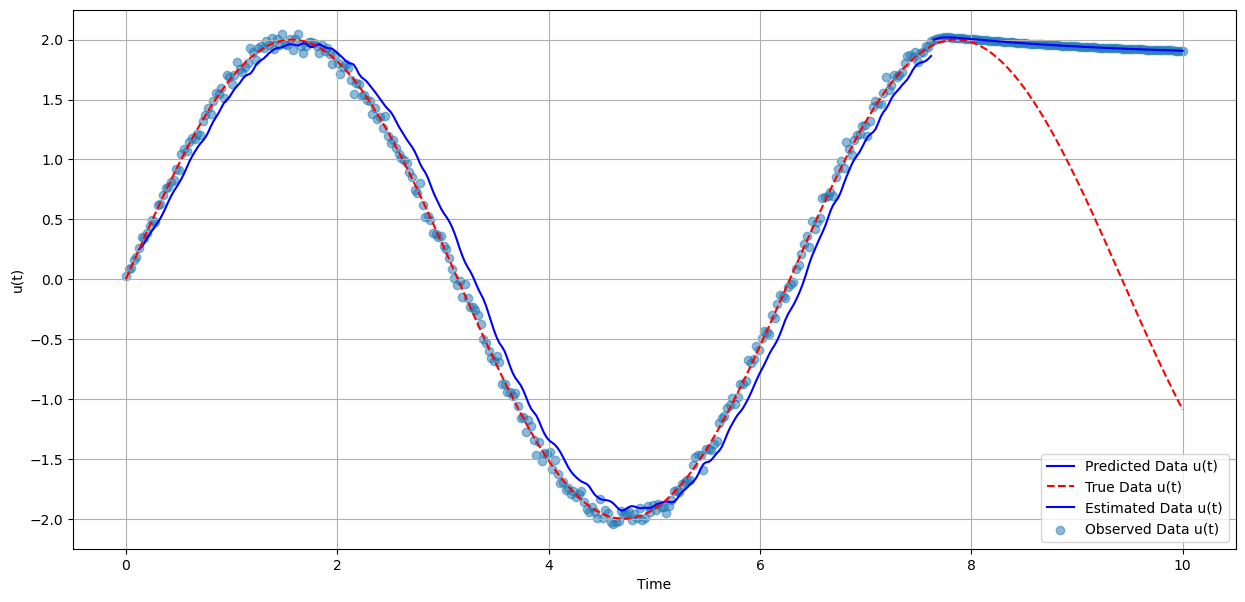

In [76]:
#result = y_pred_results[0]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
#plt.plot(t, y_train_pred, 'b', label='Predicted Solution u(t)')
#plt.plot(t_test_ho[N-1:], result['y_test_pred'].T, 'b', label='Predicted Solution u(t')

plt.plot(t[offset : 300+offset], y_train_pred, 'b', label='Predicted Data u(t)') 
plt.plot(t, y, 'r--', label='True Data u(t)') 
plt.plot(t[305:], y_noisy_embeddings[305:], 'b', label='Estimated Data u(t)')
plt.scatter(t, u_noisy, label='Observed Data u(t)', alpha=0.5) 
#plt.scatter(t[:i], u_noisy[:i], label='Observed Data u(t)', alpha=1) 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()